<a href="https://colab.research.google.com/github/jermwatt/machine_learning_refined/blob/main/notes/11_Feature_learning/11_9_Bagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter 11: Principles of Feature Learning

# 11.9 Bagging Cross-Validated Models

As we discussed in detail in [Section 11.4](https://jermwatt.github.io/machine_learning_refined/notes/11_Feature_learning/11_4_Cross_validation.html), validation data is the portion of our original dataset  we exclude at random from the training process in order to determine a proper tuned model that will faithfully represent the phenomenon generating our data.  The validation error generated by
our tuned model on this 'unseen' portion of data is the fundamental measurement tool we use to determine an appropriate cross-validated model for our entire dataset (besides, perhaps, a testing set - see Section 11.7).  However, the random nature of splitting data into training and validation poses a potentially an obvious flaw to our cross-validation process: what if the random splitting creates
training and validation portions which are not desirable representatives of the underlying phenomenon that generated them?  In other words, in practice what do we do about potentially bad training-validation splits, which can result in poorly representative cross-validated models?  

Because we *need* cross-validation in order to choose appropriate models in general, and because we can do nothing about the (random) *nature* by which we split our data for cross-validation (what better is there to simulate the 'future' of our phenomenon?), the practical solution to this fundamental problem is to simply perform several different training-validation splits, determine an appropriate cross-validated model on each split, and then *average* the resulting cross-validated models.  By averaging a set of cross-validated models, also referred to as *bagging* in the jargon of machine learning, we can *very often* both 'average out' the potentially undesirable characteristics of each model while synergizing their positive attributes (that is, while bagging is not mathematically guaranteed to produce a more effective model than any of the members averaged to create it - e.g., when all but one cross-validated model provide poor results leading to an average of mostly bad predictors - typically in practice it produces superior results).  Moreover, with *bagging* we can also effectively combine cross-validated models built from *different universal approximators*.  Indeed this is the most reasonable way of creating a single model built from different types of universal approximators in practice. 

Here we will walk through the concept of bagging or model averaging for regression, as well as two-class and multi-class classification by exploring an array of simple examples.  With these simple examples we will illustrate the superior performance of bagged models visually, but in general we confirm this using the notion of testing error (see Section 11.7) or an estimate of testing error (often employed when bagging trees - see Section 14.6).  Regardless, the principles detailed here can be employed more widely as well to any machine learning problem.   As we will see, the best way to average/bag a set of cross-validated regression models is by taking their *median* and cross-validated classification models by computing the *mode* of their predicted labels.

In [1]:
# install github clone - allows for easy cloning of subdirectories
!pip install github-clone
from pathlib import Path 

# clone images
if not Path('chapter_11_images').is_dir():
    !ghclone https://github.com/neonwatty/machine-learning-refined-notes-assets/tree/main/notes/11_Feature_learning/chapter_11_images
else:
    print('chapter_11_images already cloned!')
        

# image paths
image_path_1 = "chapter_11_images/Figure_11_47.png"
image_path_2 = "chapter_11_images/Figure_11_48.png"
image_path_3 = "chapter_11_images/Figure_11_49.png"
image_path_4 = "chapter_11_images/Figure_11_50.png"
image_path_5 = "chapter_11_images/Figure_11_51.png"

# standard imports
import matplotlib.pyplot as plt
from matplotlib import gridspec
import IPython, copy
from IPython.display import Image, HTML

# import autograd-wrapped numpy
import autograd.numpy as np

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
chapter_11_images already cloned!


## Bagging cross-validated regression models

Here we explore several ways of bagging a set of cross-validated models for simple nonlinear regression dataset.  As we will see, more often than not the best way to bag (or average) cross-validated regression models is by taking their *median* (as opposed to their *mean*).

---

#### <span style="color:#a50e3e;">Example 11.16:</span>   Bagging cross-validated regression models

In the set of small panels in the left side of [Figure 11.47](#figure-11-47) we show $10$ different training-validation splits of a prototypical nonlinear regression dataset, where
$\frac{4}{5}$ of the data in each instance has been used for training (colored light blue) and $\frac{1}{5}$ is used for validation (colored yellow).  Plotted with each split of the original data is the corresponding cross-validated spanning set model found by naively cross-validating (see [Section 11.4](https://jermwatt.github.io/machine_learning_refined/notes/11_Feature_learning/11_4_Cross_validation.html)) the range of complete polynomial models of degree $1$ to $20$.  As we can see, while *many* of these cross-validated models perform quite well, several of them (due to the particular training-validation split on which they are based) severely *underfit* or *overfit* the original dataset.  In each instance the poor performance is completely due to the particular underlying (random) training-validation split, which leads cross-validation to a validation error minimizing tuned model that still does not represent the true underlying phenomenon very well.  By taking an *average* (here the *median*) of the $10$ cross-validated models shown in these small panels we can average-out the poor performance of this handful of bad models, leading to a final bagged model that fits the data quite well - as shown in the large right panel of [Figure 11.47](#figure-11-47).  

---

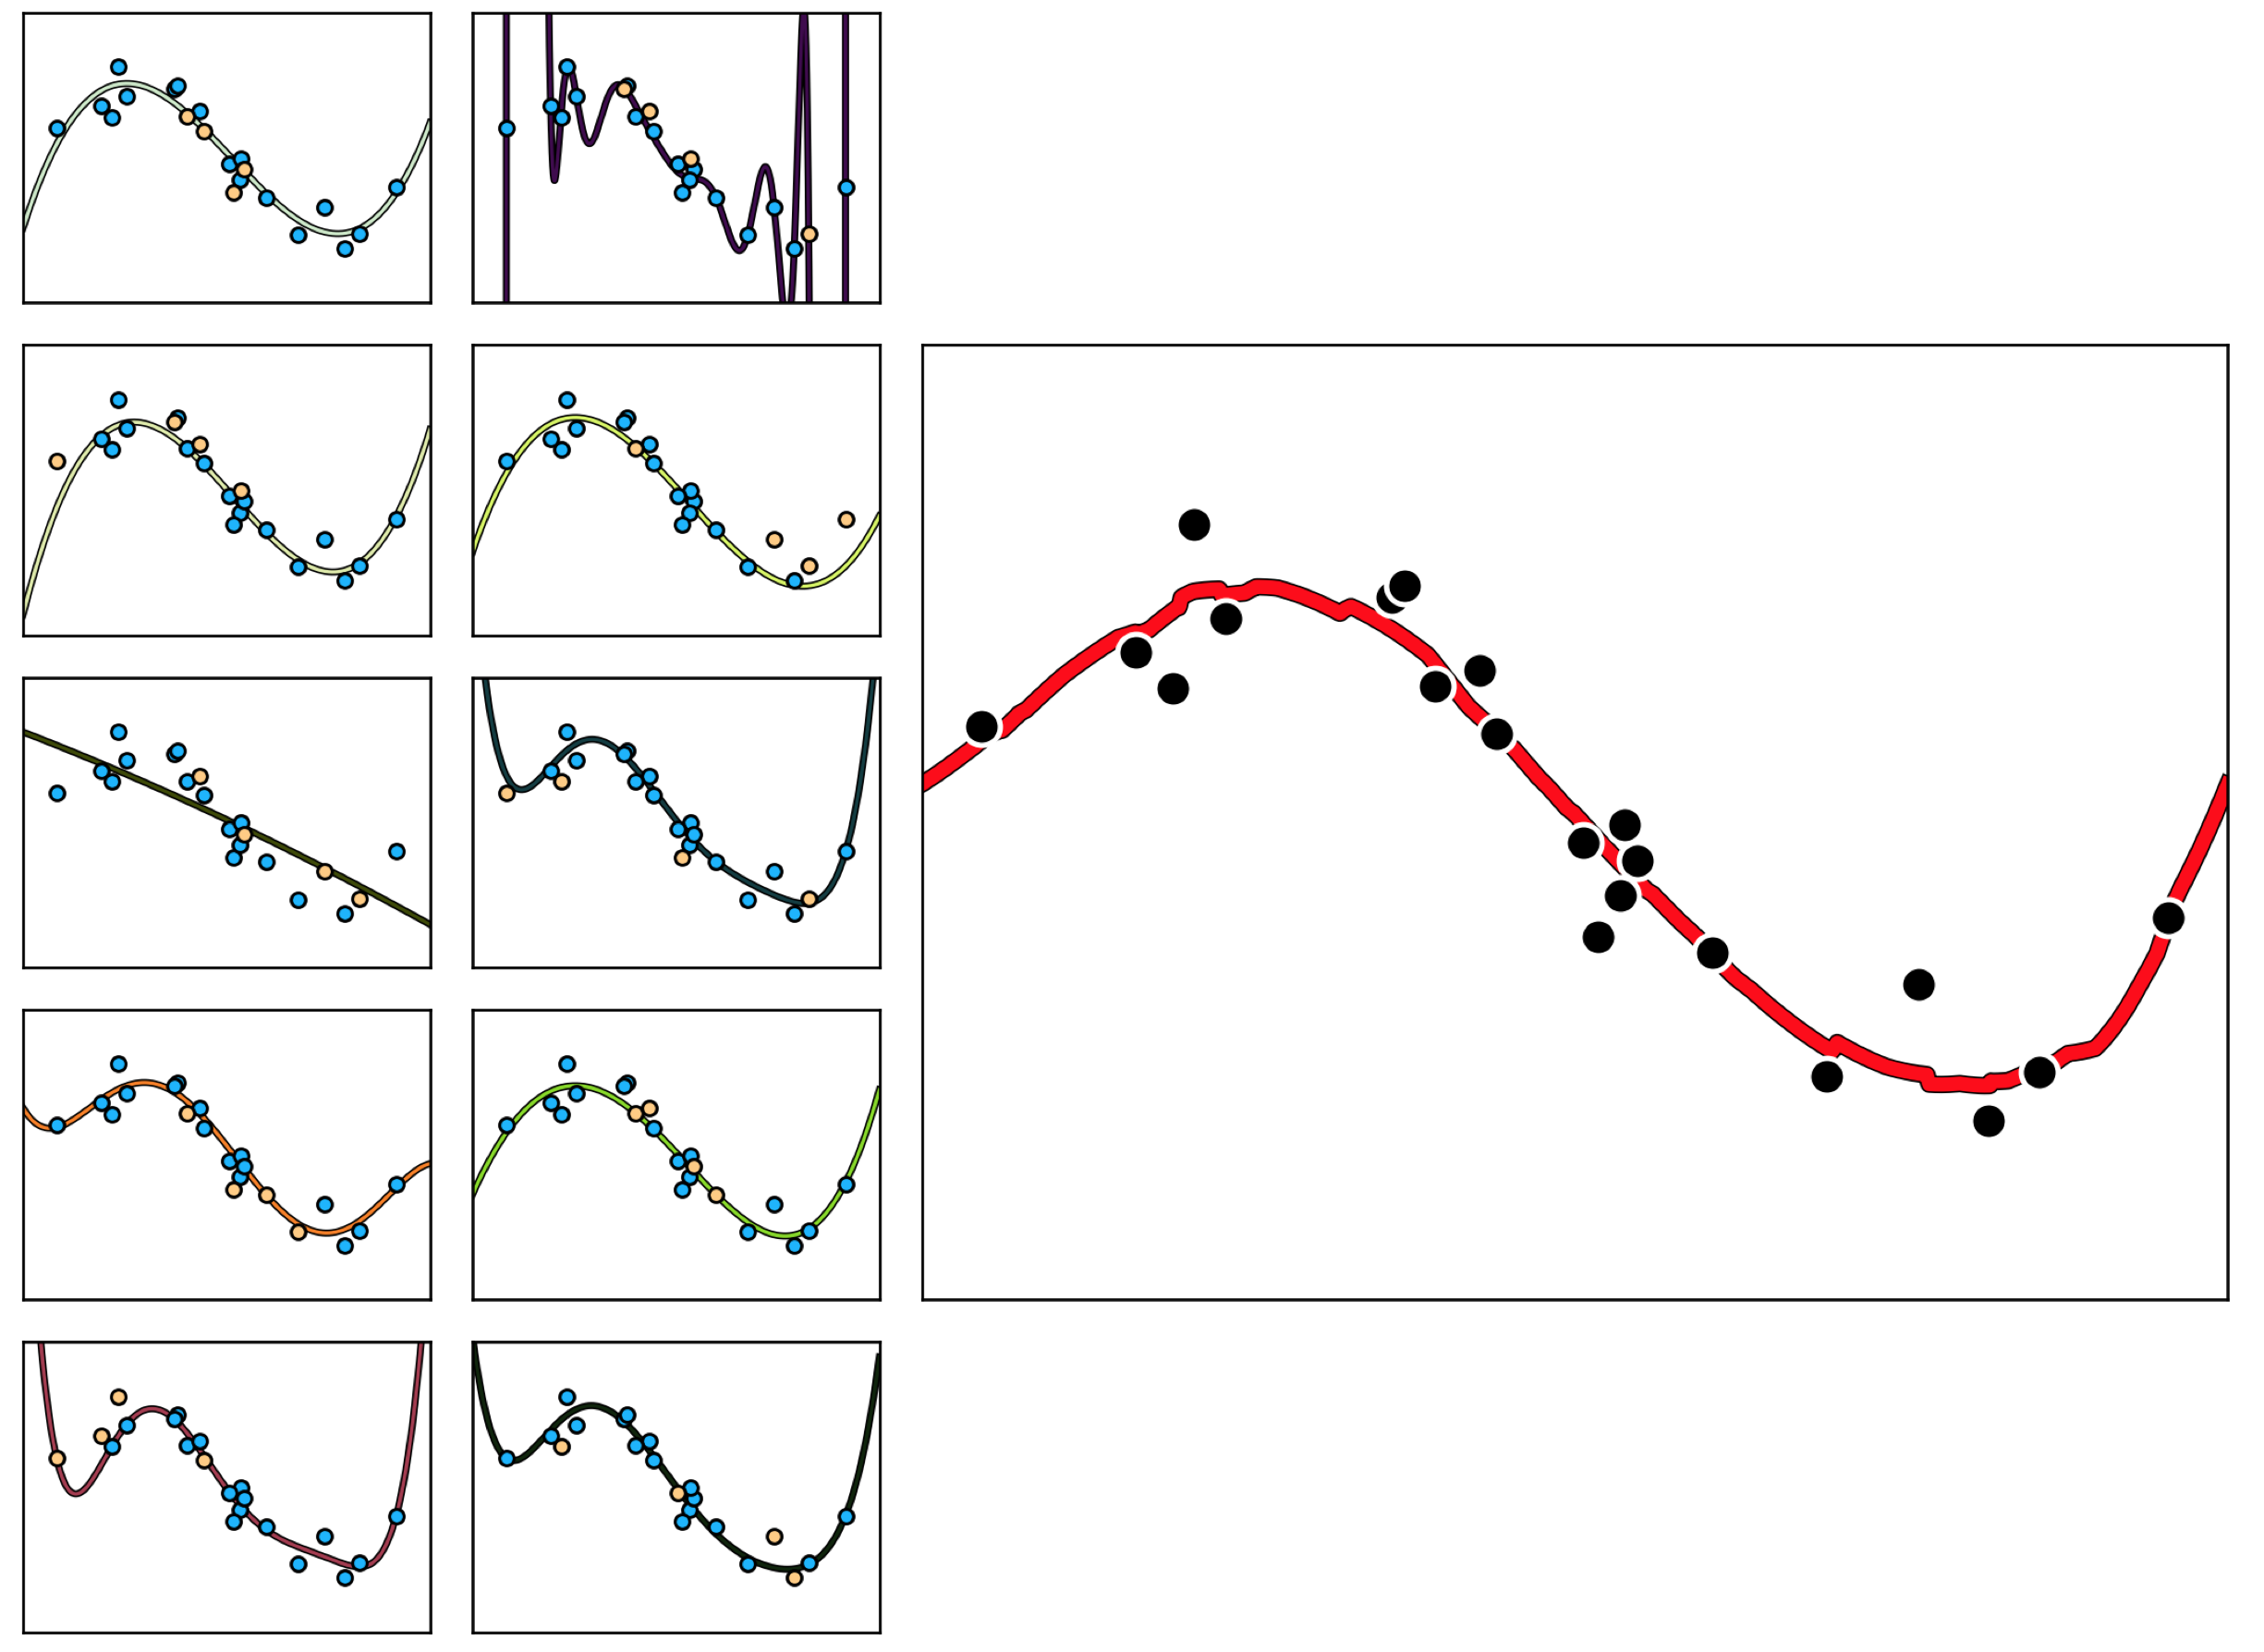

In [2]:
Image(image_path_1)

<a id='figure-11-47'></a>
<figure>
<p>
</p>
<figcaption> <strong>Figure: 11.47 </strong> <em> 
(left column) The results of applying cross-validation to $10$ different random training-validation splits of a nonlinear regression dataset, with each resulting model shown in one of the $10$ small panels.  Here the training and validation portions in each instance are colored light blue and yellow, respectively. (right column) The fit, shown in red, resulting from the bagging or average (here the median) of the $10$ models whose fits are shown on the left. 
</em>
</figcaption>
</figure>

---

More generally, if we created $E$ cross-validated regression models $\left\{\text{model}_{e}\left(\mathbf{x},\Theta_e^{\star}\right)\right\}_{e=1}^E$, each trained on a different training-validation split of the data, then our median model $\text{model}\left(\mathbf{x},\Theta\right)$ as 

\begin{equation}
    \text{model}\left(\mathbf{x},\Theta^{\star} \right) = \text{median}\left\{ \text{model}_{e}\left(\mathbf{x},\Theta_e^{\star}\right)\right\}_{e=1}^E.
\end{equation}

Note here the parameter set $\Theta^{\star}$ of the median model contains all of tuned parameters $\left\{\Theta_e^{\star}\right\}_{e=1}^E$ from the models in cross-validated set.
    
Why average our cross-validated models using the *median* as opposed to say the *mean*?  Because the *mean* of a long list of numbers is far more sensitive to *outliers* than is the median.  In using the median of a large set of cross-validated models - and thus by using the median of their corresponding fits to the entire dataset - we ameliorate the effect of severely underfitting / overfitting cross-validated model on our final bagged model.  In the top row of [Figure 48](#figure-11-48) we show the regression dataset shown previously along with the individual cross-validated fits (left panel), the median bagged model (middle panel), and the mean bagged model (right panel). Here the mean model is highly affected by the few overfitting models in the group, and ends up being far too oscillatory to fairly represent the phenomenon underlying the data. The median is not affected in this way, and is a much better representative.

---

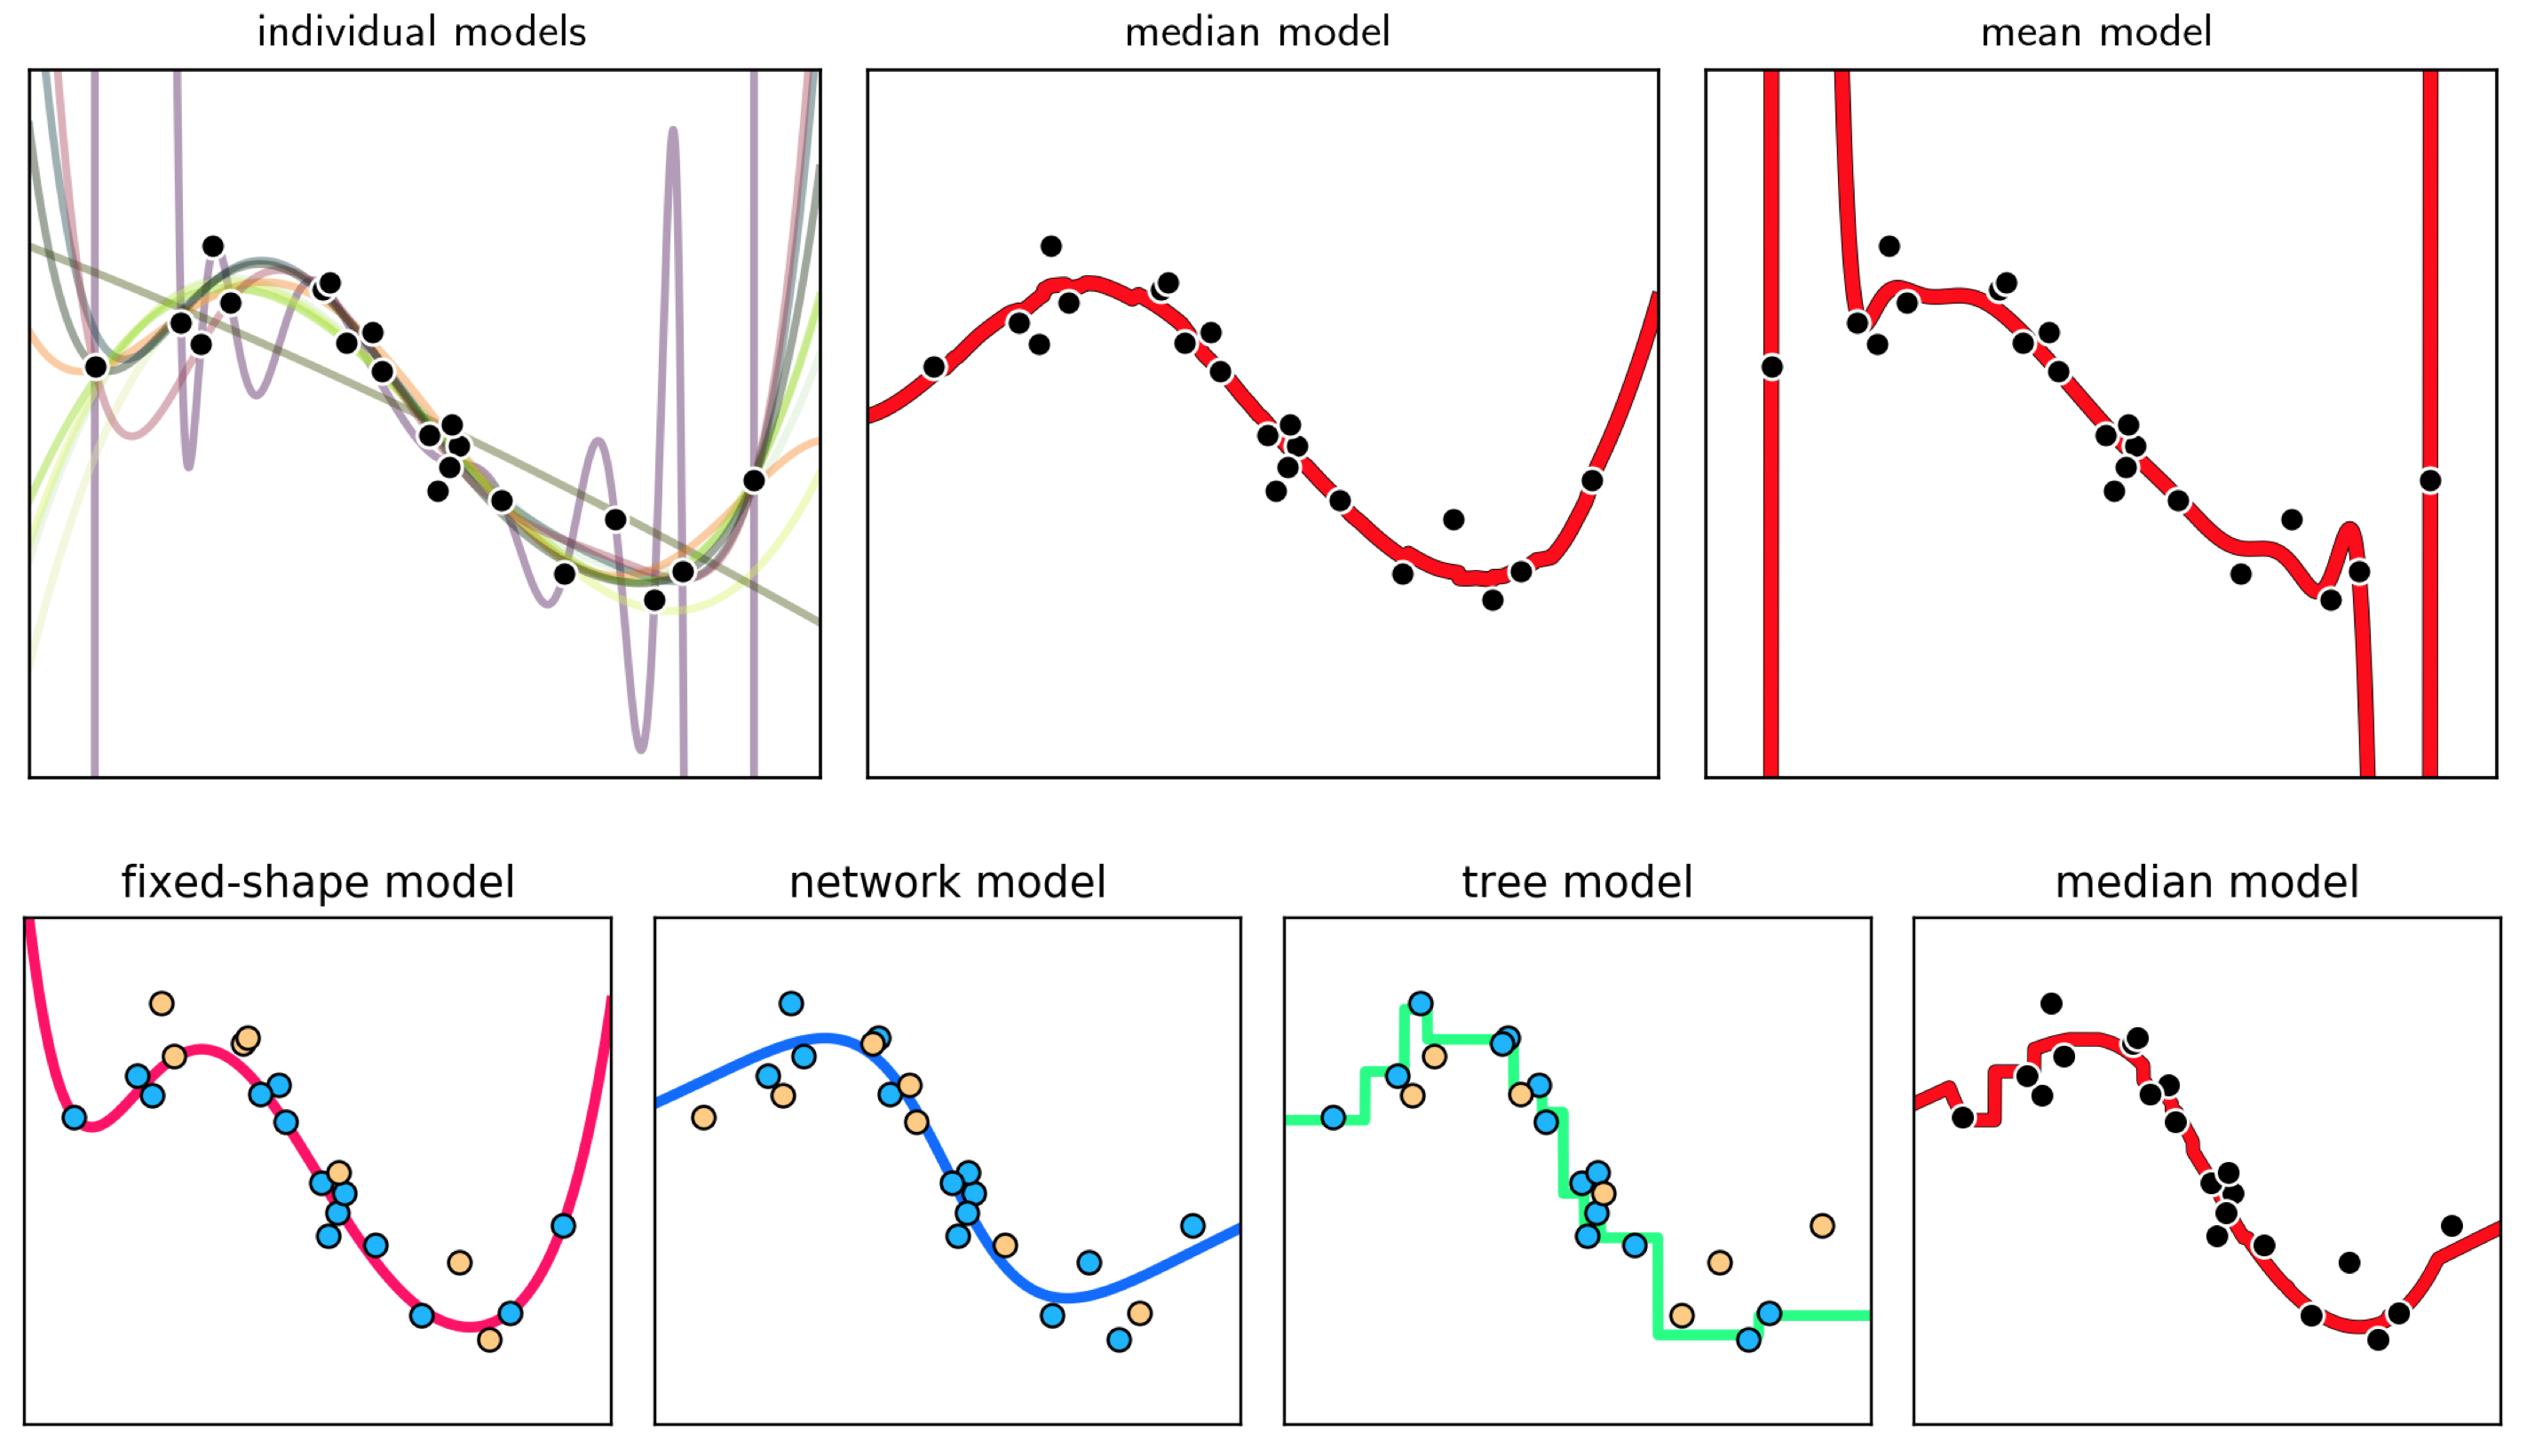

In [3]:
Image(image_path_2)

<a id='figure-11-48'></a>
<figure>
<p>
</p>
<figcaption> <strong>Figure: 11.48 </strong> <em> 
(top row) The $10$ individual cross-validated models first shown in the left column of Figure 11.47 shown together.  The median and mean of these models are shown in the middle and right panel, respectively.  With regression, bagging via the median tends to produce more trustworthy results as it is less sensitive to outliers. (bottom row) Cross-validated fixed-shape polynomial (left panel), neural network (second panel from the left), and tree-based (second panel from the right) models.  The median of these three models is shown in the right panel.  See text for further details.
</em>
</figcaption>
</figure>

---

When we bag we are simply averaging various cross-validated models with the desire to both avoid bad aspects of poorly performing models, and jointly leverage strong elements of the well performing ones.  Nothing in
this notion prevents us from bagging together cross-validated models built using different universal approximators, and indeed this is the most organized way of combining different types of universal approximators in practice.

In the bottom row of [Figure 11.48](#figure-11-48) we show the result of a cross-validated polynomial model (left panel) built by naively cross-validating full polynomials of degree $1$ through $10$, a naively cross-validated (see [Section 11.4](https://jermwatt.github.io/machine_learning_refined/notes/11_Feature_learning/11_4_Cross_validation.html)) neural network model (in the second to the left panel) built by comparing models consisting of $1$ through $10$ units, and a cross-validated stump model (second to the right panel) built via boosting (see [Section 11.5](https://jermwatt.github.io/machine_learning_refined/notes/11_Feature_learning/11_5_Boosting.html)).  Each cross-validated model uses a different training-validation split of the original dataset, and the bagged (median) of these models is shown in the right panel.

---

##   Bagging cross-validated classification models

The principle behind bagging cross-validated models holds analogously for classification tasks, just as it does with regression.  Because we cannot be certain whether or not a certain (randomly chosen) validation set accurately represents the 'future data' from a given phenomenon well, the averaging (or bagging)
of a number of cross-validated classification models provides a way of 'averaging out' poorly representative portions of some models while combining the various models' positive characteristics.

Because the predicted output of a (cross-validated) classification model is a *discrete* label via, e.g., passing the model through the $\text{sign}$ function in the case of two-class classification (when employing label values $y\in\left\{-1,+1\right\}$ as detailed in Chapter 6) or the *fusion rule* in the multi-class setting (as detailed in Chapter 7) the average used to bag cross-validated classification models is the *mode* (i.e., the
most popularly predicted label).

#### <span style="color:#a50e3e;">Example 11.17:</span>   Bagging cross-validated two-class classification models

In the set of small panels in the left column of [Figure 11.49](#figure-11-49) we show $5$ different training-validation splits of the prototypical two-class classification dataset, where $\frac{2}{3}$ of the data in each instance is used for training and $\frac{1}{3}$ is used for validation (the edges of these points are colored yellow).  Plotted with each split of the original data is the nonlinear decision boundary corresponding to each  cross-validated model found by naively cross-validating the range of complete polynomial models of degree $1$ to $8$.  *Many* of these cross-validated models perform quite well, but several of them (due to the particular training-validation split on which they are based) severely *overfit* the original dataset.  By bagging these models using the most popular prediction to assign labels (i.e., the *mode* of these cross-validated model predictions) we produce an appropriate decision boundary for the data shown in the right panel of the Figure.

---

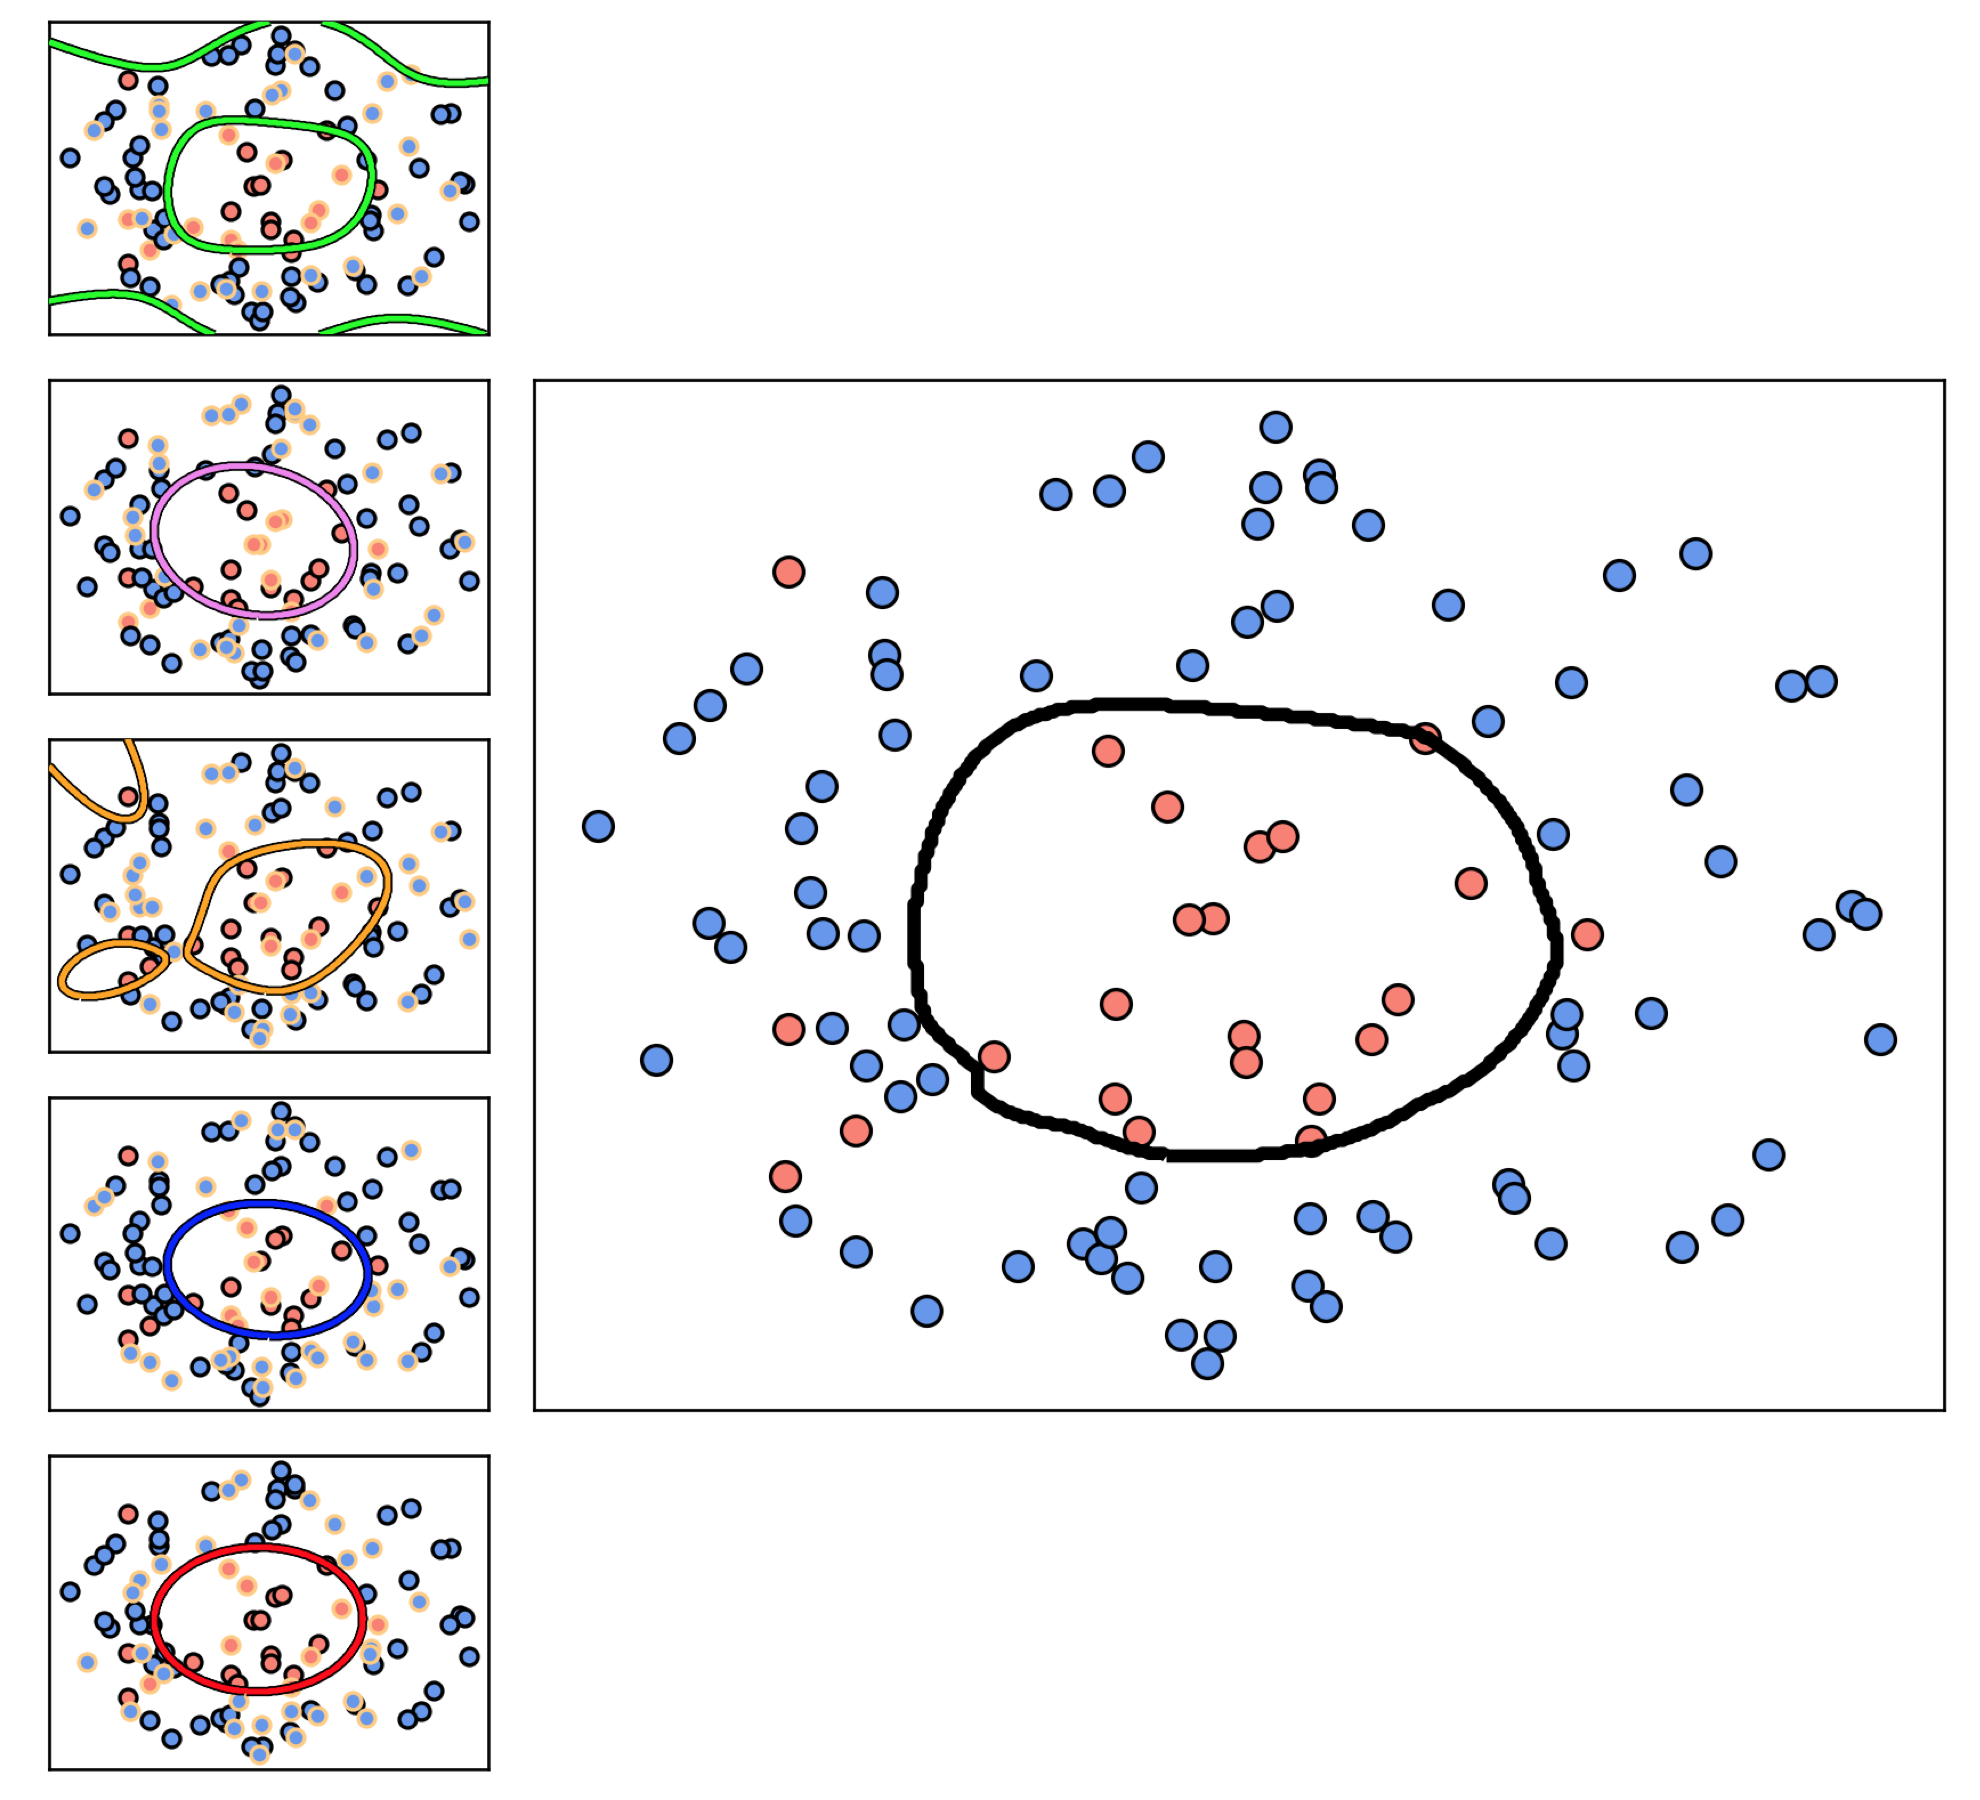

In [4]:
Image(image_path_3)

<a id='figure-11-49'></a>
<figure>
<p>
</p>
<figcaption> <strong>Figure: 11.49 </strong> <em> 
(left column) $5$ models cross-validated on random training-validation splits of the data, with the validation data in each instance highlighted with a yellow outline.  The corresponding nonlinear decision boundary provided by each model is shown in each panel.  Several models, due to the split of the data on which they were built, severely overfit.  (right column) The original dataset with the decision boundary provided by the bag of the $5$ cross-validated models - by taking their mode - provides a very good decision boundary for the data.
</em>
</figcaption>
</figure>

---

---

In the top-middle panel of [Figure 11.50](#figure-11-50)  we illustrate the decision boundary from each of $5$ naively cross-validated models each built using $B = 20$ single layer $\text{tanh}$ units trained on different training / validation splits
of the dataset shown in the top-left panel of the Figure.  In each instance $\frac{1}{3}$ of the dataset is randomly chosen as validation (and is highlighted in yellow), and the appropriate tuning of each model's parameters is achieved via $\ell_2$ regularization based cross-validation (see [Section 11.6](https://jermwatt.github.io/machine_learning_refined/notes/11_Feature_learning/11_6_Regularization.html)) using a dense range of values for $\lambda \in [0,0.1]$.  In the top-middle panel we plot the diverse set of decision boundaries associated to each cross-validated model on top of the original dataset, each colored differently so they can be distinguished visually. While some of these decision boundaries separate the two classes quite well, others do a poorer job. In the top-right panel we show the decision boundary of the bag, created by taking the mode of the predictions from these cross-validated models, which performs quite well.

---

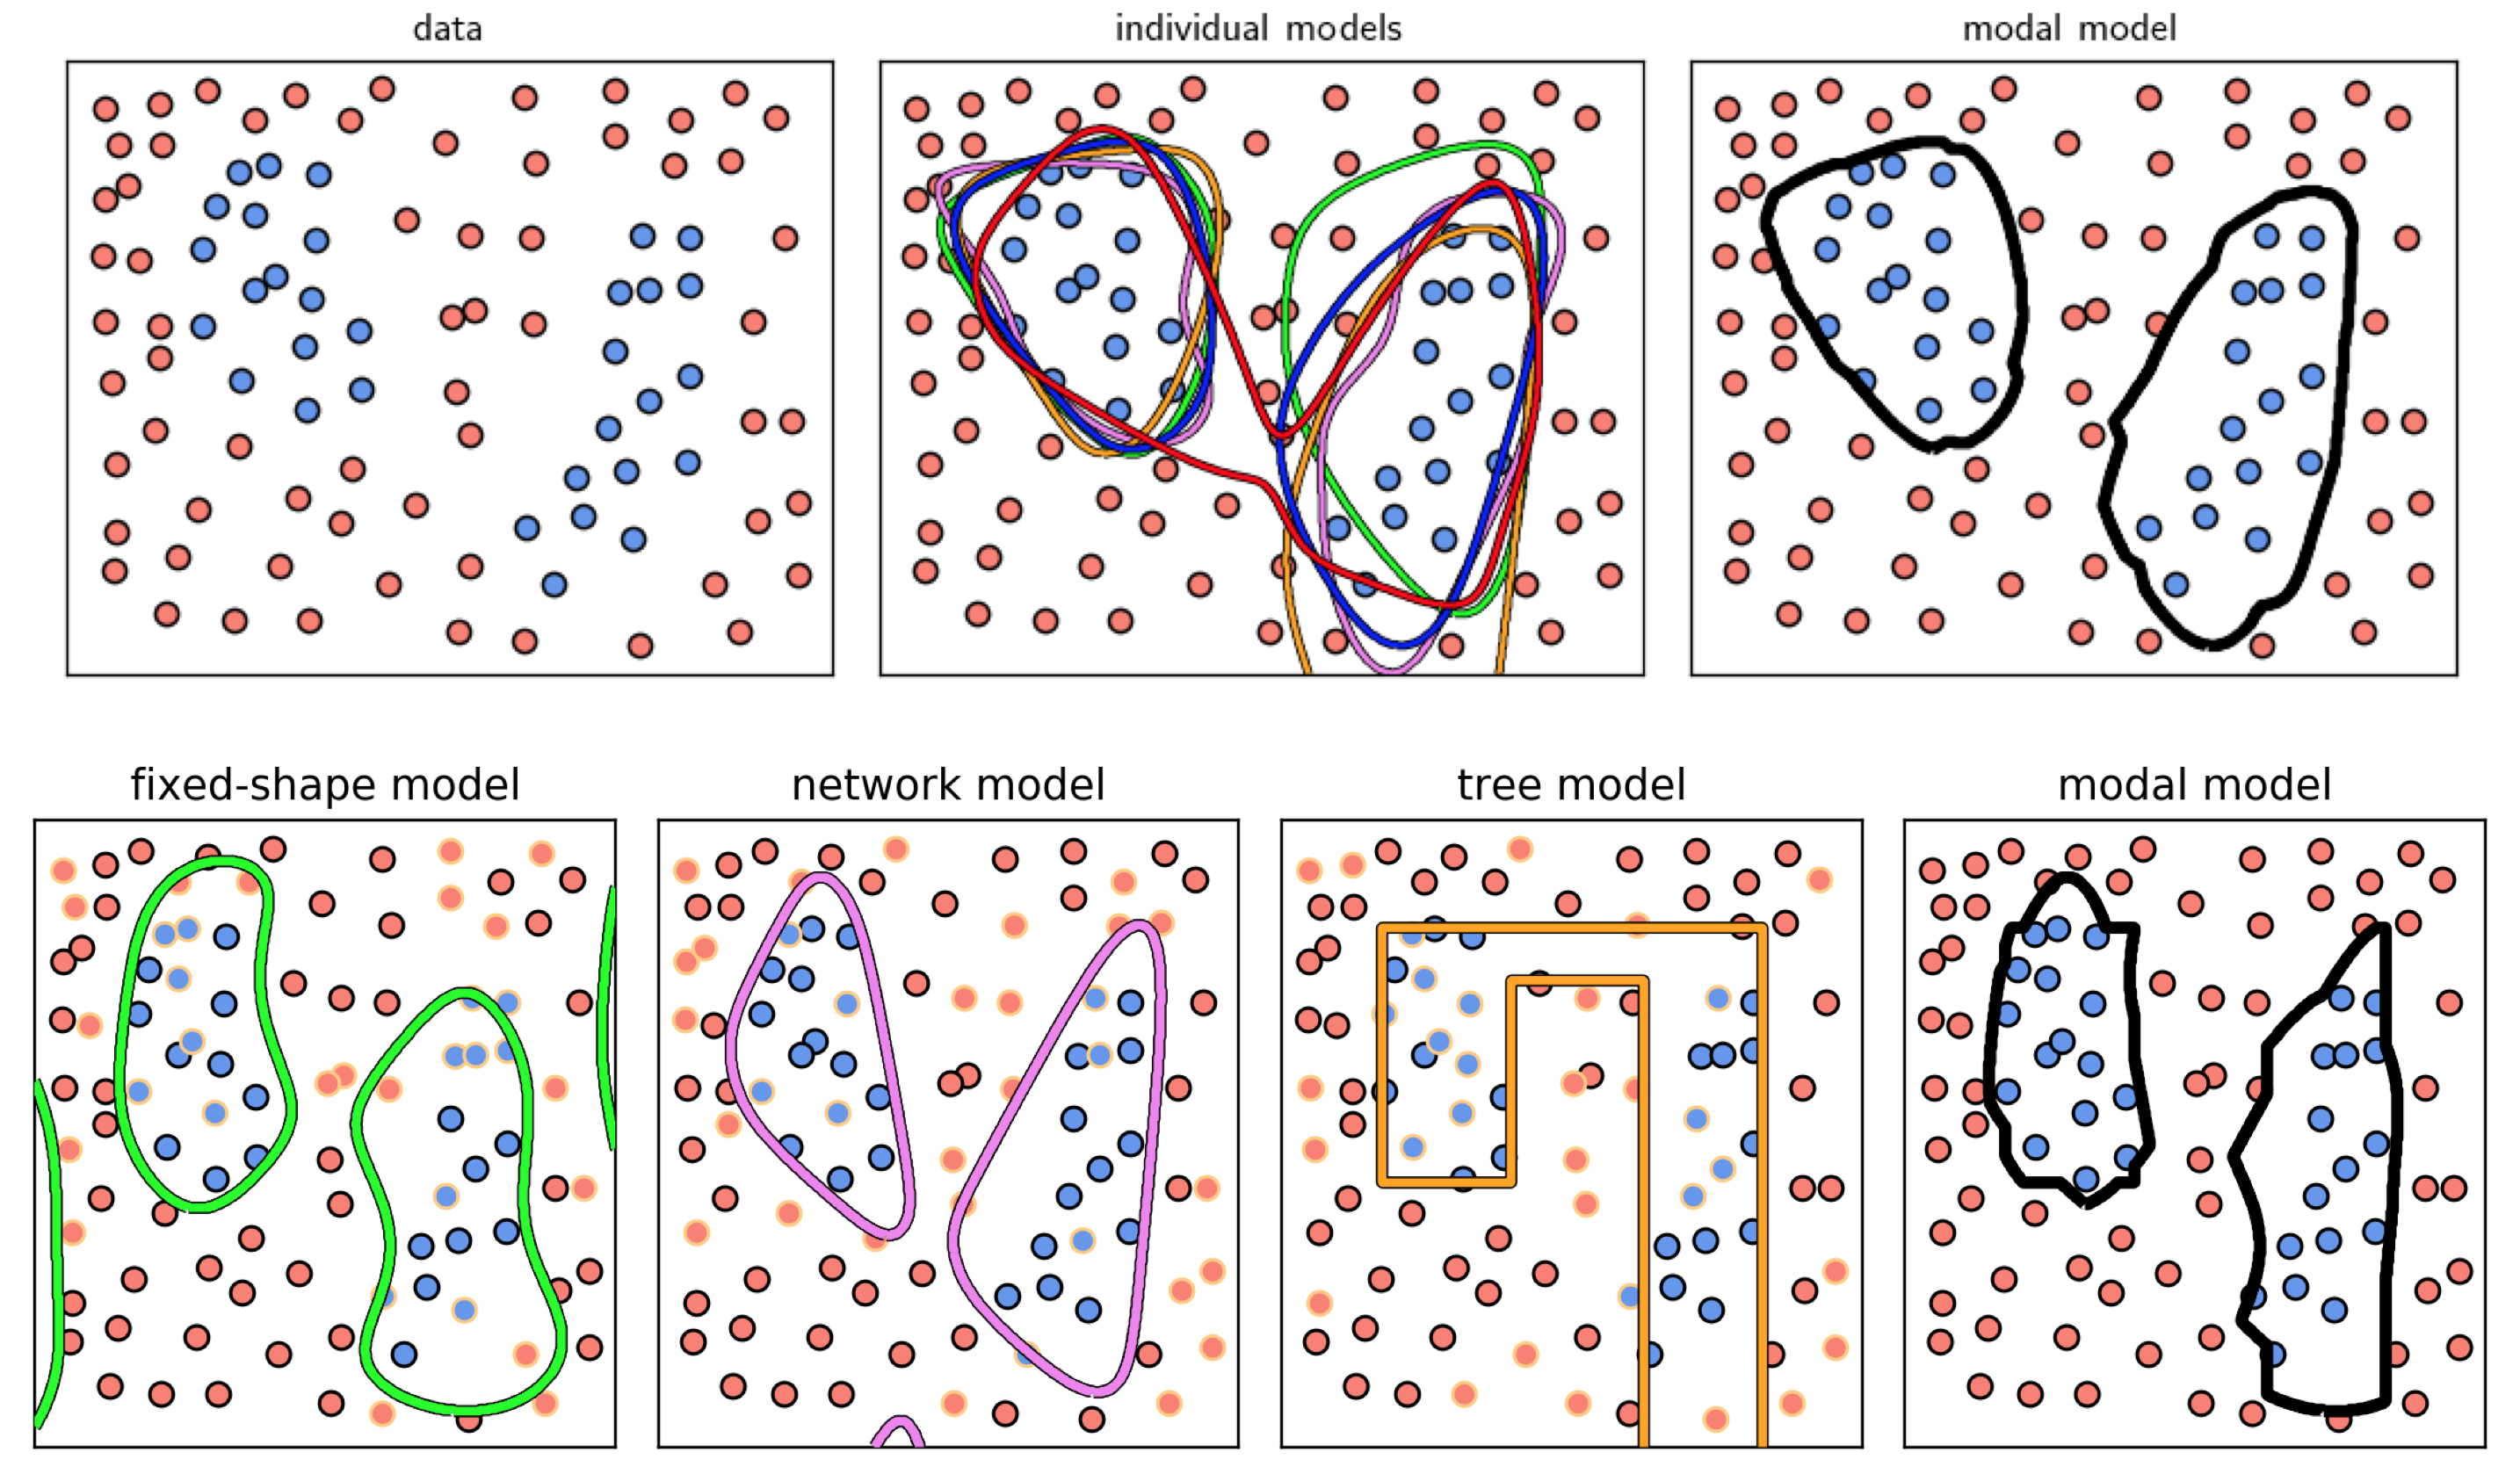

In [5]:
Image(image_path_4)

<a id='figure-11-50'></a>
<figure>
<p>
</p>
<figcaption> <strong>Figure: 11.50 </strong> <em> 
(top row) (middle panel) The decision boundaries, each shown in a different color, resulting from $5$ models cross-validated on different training-validation splits of the dataset shown in the left panel.  (right panel) The decision boundary resulting from the mode, the 'modal model,' of the $5$ cross-validated models whose decision boundaries are shown in the middle panel.  (bottom row) The decision boundaries provided by a cross-validated fixed-shape model (left panel), neural network model (second from the left panel), and tree-based model (second panel from the right).  In each instance the validation portion of the data is highlighted in yellow.  (right panel)  The decision boundary provided by the mode of these three models.  See text for further details.
</em>
</figcaption>
</figure>

---

As with regression, with classification we can also combine cross-validated models built from different universal approximators.  We illustrate this in the bottom row of [Figure 11.50](#figure-11-50) using the same dataset.   In particular we show the result of a naively cross-validated polynomial model (left panel) built by comparing full polynomials of degree $1$ through $10$, a naively cross-validated neural network model (in the second to the left panel) built by comparing models consisting of $1$ through $10$ units, and a cross-validated stump model (second to the right panel) built via boosting over a range of $20$ units.  Each cross-validated model uses a different training-validation split of the original dataset (the validation data portion highlighted in yellow in each panel), and the bag (mode) of these models shown in the right panel performs quite well.

---

#### <span style="color:#a50e3e;">Example 11.18:</span>   Bagging multi-class models

In this example we illustrate the bagging of various cross-validated multi-class models on two different datasets, shown in the left column of [Figure 11.51](#figure-11-51).  In each case we naively cross-validate  full polynomial models of degree $1$ through $5$, with $5$ cross-validated models learned in total.  In the middle column of the Figure we show the decision boundaries provided by each cross-validated model in distinct colors, while the decision boundary of the final modal model is shown in the right column for each dataset, which perform very well.

---

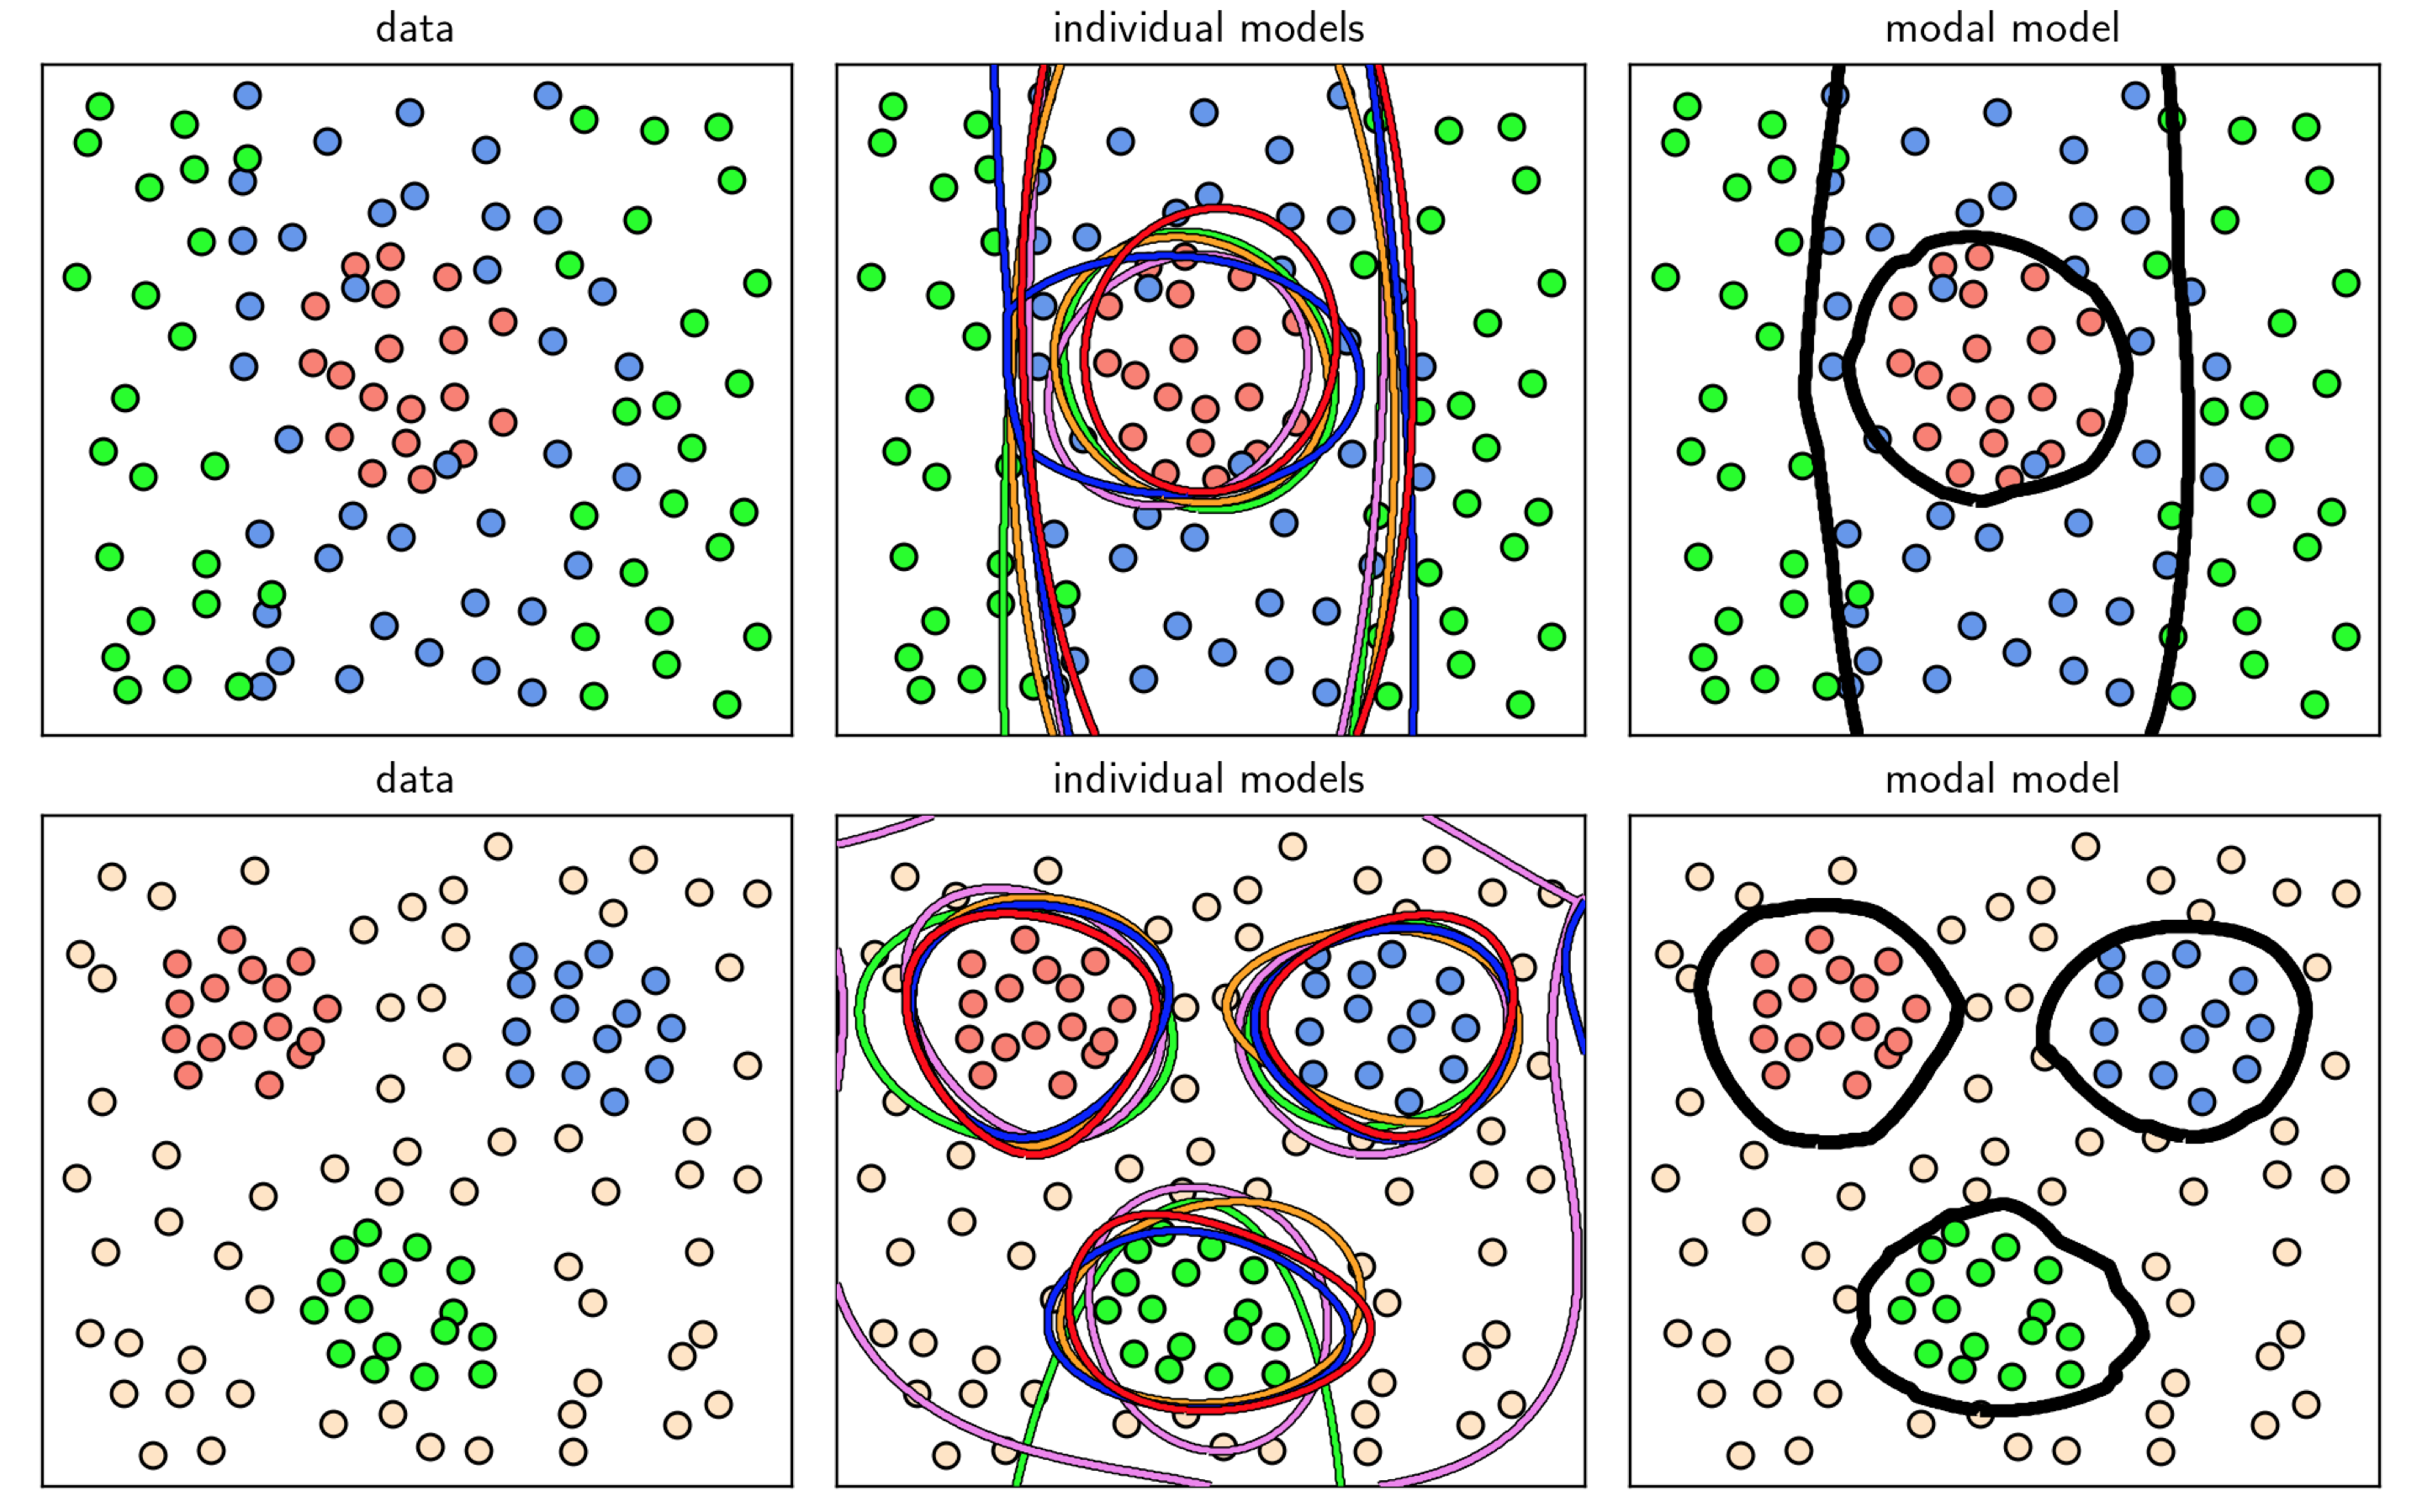

In [6]:
Image(image_path_5)

<a id='figure-11-51'></a>
<figure>
<p>
</p>
<figcaption> <strong>Figure: 11.51 </strong> <em> 
left column) Two multi-class datasets.  (middle column) The decision boundaries resulting from $5$ cross-validated models, each shown as a distinct color.  (right column) The decision boundary provided by the mode-based model of the various cross-validated models whose decision boundaries are shown in the middle column.
</em>
</figcaption>
</figure>

---

## How many models should we bag in practice?

Note that in the Examples of this Section the exact number of cross-validated models bagged were set somewhat arbitrarily.  Like other important parameters involved with cross-validation (e.g., the portion of a dataset to reserve for validation) there is in general no magic number (of cross-validated models) used generally in practice for bagging.  Ideally if we knew that any random validation portion of a dataset generally represented it well, which is often true with very large datasets, there would be less of a need to ensemble multiple cross-validated models where each was trained on a different training/validation split of the original data, since we could trust the results of a single cross-validated model more.  Indeed in such instances we could instead bag a range of models trained on a single training/validation split in order to achieve similar improvements over a single model.   On the other hand, the less we could trust in the faithfulness of a random validation portion to represents a phenomenon at large, the less we could trust an individual cross-validated model and hence we might wish to ensemble more of them to help average our poorly performing models resulting from bad splits of the data.  Since this is generally impossible to determine in practice often practical considerations (e.g., computation power, dataset size) determine if bagging is used and if so how many models are employed in the average.

## Ensembling: Bagging vs Boosting

The bagging technique described here, wherein we combine a number of different models each cross-validated independently of the others, is a primary example of what is referred to as *ensembling* in the jargon of machine learning.  An *ensembling method* (as the name ‘ensemble’ implies) generally refers to any method of combining different models in a machine learning context.  Bagging certainly falls into this general category, as does the general *boosting* approach to cross-validation described in [Section 11.5](https://jermwatt.github.io/machine_learning_refined/notes/11_Feature_learning/11_5_Boosting.html).  However, these two ensembling methods are very different from one another.

With boosting we build up a *single* cross-validated model by gradually *adding* together simple models consisting of a single universal approximator unit.  Each of the constituent models involved in boosting are trained in a way that makes each individual model *dependent* on its predecessors (who are trained first).  On the other hand with bagging (as we have seen) we  *average* together *multiple cross-validated* models that have been trained *independently* of each other.  Indeed any one of those cross-validated models in a bagged ensemble can itself be a boosted model.